# **Random Forest ile Enerji Tüketimi ve Menzil Tahmini**


Bu not defteri, gerçek araç verilerini kullanarak elektrikli araçların menzil ve enerji tüketimini tahmin edebilen bir makine öğrenmesi modeli (Random Forest Regresyon) geliştirme sürecini detaylandırmaktadır. Ayrıca, hız, ivme, yol eğimi ve batarya durumu gibi faktörlerin enerji tüketimine anlık etkileri analiz edilmiş ve sonuçlar görselleştirilmiştir.


### **Random Forest Seçilme Sebepleri**

1. **Doğrusal Olmayan İlişkileri Yakalama:**
Enerji tüketimi hız, ivme, yol eğimi ve batarya durumu gibi birçok değişkene bağlıdır. Bu ilişkiler çoğu zaman doğrusal değildir. Random Forest, bu karmaşık ve doğrusal olmayan ilişkileri yakalayabilir.

2. **Aykırı Değerlere Karşı Dayanıklılık:**
Gerçek araç verilerinde sensör hataları veya ani sürüş davranışları gibi aykırı değerler bulunabilir. Random Forest, tek bir ağaç yerine birçok ağacı birleştirdiği için bu tür aykırılıklara karşı daha dayanıklıdır.

3. **Özellik Önemini Belirleme (Feature Importance):**
Model, hangi değişkenlerin enerji tüketimine daha fazla etki ettiğini ölçebilir. Bu sayede hız, eğim, sıcaklık gibi faktörlerin menzil üzerindeki rolü sayısal olarak incelenebilir.

4. **Genel Performans ve Kararlılık:**
Aşırı öğrenmeye (overfitting) karşı güçlüdür ve eğitim–test performansı genellikle dengelidir. Gerçek verilerle yapılan modellemede güvenilir sonuçlar sağlar.

## **1. Kütüphaneler**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


## **2. Veri Yükleme Ve Ön İncelemeler**

In [2]:
# Model eğitimi için kullanılacak random state değişkeni
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Seçtiğimiz target
TARGET = "soc_net_per_s_smooth5"

uploaded = files.upload()
df = pd.read_csv("ev_dataset_multi_target.csv")
DATA_PATH = "ev_dataset_multi_target.csv"
df.head()

Saving ev_dataset_multi_target.csv to ev_dataset_multi_target.csv


,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Experiment_ID,Average_Velocity,Load,Direction,Season,...,speed_ms,acc_ms2,power_W,cell_voltage_diff,SoC,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s
0,3316.50,12.56,84.68,49.687500,14.17,Experiment_1,15,Loaded,CISAR,Summer,...,0.044935,0.000000,704.071875,7.54,60.030,0.000,0.0028,0.0048,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,Experiment_1,15,Loaded,CISAR,Summer,...,0.488215,0.443281,1505.151344,7.47,60.022,0.008,0.0028,0.0048,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,Experiment_1,15,Loaded,CISAR,Summer,...,0.968013,0.479798,1707.815950,7.83,60.020,0.002,0.0028,0.0048,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,Experiment_1,15,Loaded,CISAR,Summer,...,1.348039,0.380026,2064.904725,7.84,60.020,-0.000,0.0040,0.0048,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,Experiment_1,15,Loaded,CISAR,Summer,...,1.649832,0.301792,2350.466737,7.53,60.016,0.004,0.0032,0.0048,0.0,0.0


In [3]:
# Veri yükleme ve hızlı EDA
df = pd.read_csv(DATA_PATH)

print("Şekil:", df.shape)
print("Sütunlar:", list(df.columns))
print("\nTip bilgisi:")
display(df.dtypes)


Şekil: (14657, 21)
Sütunlar: ['CELL_V_AVG', 'Torque_Measured', 'MotorTemperature', 'DC_Link_Voltage', 'DC_Link_Current', 'Experiment_ID', 'Average_Velocity', 'Load', 'Direction', 'Season', 'slope', 'speed_ms', 'acc_ms2', 'power_W', 'cell_voltage_diff', 'SoC', 'soc_net_per_s', 'soc_net_per_s_smooth5', 'soc_net_per_s_smooth10', 'soc_net_per_s_30s', 'soc_net_per_s_60s']

Tip bilgisi:


,0
CELL_V_AVG,float64
Torque_Measured,float64
MotorTemperature,float64
DC_Link_Voltage,float64
DC_Link_Current,float64
Experiment_ID,object
Average_Velocity,int64
Load,object
Direction,object
Season,object


In [4]:
print("\nEksik değer sayıları (büyükten küçüğe):")
display(df.isna().sum().sort_values(ascending=False))


Eksik değer sayıları (büyükten küçüğe):


,0
CELL_V_AVG,0
Torque_Measured,0
MotorTemperature,0
DC_Link_Voltage,0
DC_Link_Current,0
Experiment_ID,0
Average_Velocity,0
Load,0
Direction,0
Season,0


-> Daha önce veri temizleme işlemi yaptığımız için verilerimiz eksiksiz.

In [5]:
display(df.head(10))

,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Experiment_ID,Average_Velocity,Load,Direction,Season,...,speed_ms,acc_ms2,power_W,cell_voltage_diff,SoC,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s
0,3316.50,12.56,84.68,49.687500,14.17,Experiment_1,15,Loaded,CISAR,Summer,...,0.044935,0.000000,704.071875,7.54,60.030,0.000,0.0028,0.0048,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,Experiment_1,15,Loaded,CISAR,Summer,...,0.488215,0.443281,1505.151344,7.47,60.022,0.008,0.0028,0.0048,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,Experiment_1,15,Loaded,CISAR,Summer,...,0.968013,0.479798,1707.815950,7.83,60.020,0.002,0.0028,0.0048,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,Experiment_1,15,Loaded,CISAR,Summer,...,1.348039,0.380026,2064.904725,7.84,60.020,-0.000,0.0040,0.0048,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,Experiment_1,15,Loaded,CISAR,Summer,...,1.649832,0.301792,2350.466737,7.53,60.016,0.004,0.0032,0.0048,0.0,0.0
5,3304.21,29.42,84.70,49.276250,70.61,Experiment_1,15,Loaded,CISAR,Summer,...,1.957071,0.307239,3479.396012,8.38,60.010,0.006,0.0040,0.0048,0.0,0.0
6,3298.47,33.58,84.76,49.096875,93.46,Experiment_1,15,Loaded,CISAR,Summer,...,2.487745,0.530674,4588.593937,8.64,60.006,0.004,0.0060,0.0057,0.0,0.0
7,3294.14,33.22,84.72,49.003125,104.97,Experiment_1,15,Loaded,CISAR,Summer,...,3.013468,0.525723,5143.858031,11.22,60.000,0.006,0.0068,0.0058,0.0,0.0
8,3292.91,30.64,84.76,48.968750,104.54,Experiment_1,15,Loaded,CISAR,Summer,...,3.434343,0.420875,5119.193125,9.23,59.990,0.010,0.0074,0.0061,0.0,0.0
9,3291.39,30.00,84.70,48.928125,109.32,Experiment_1,15,Loaded,CISAR,Summer,...,3.786765,0.352421,5348.822625,13.79,59.982,0.008,0.0084,0.0070,0.0,0.0


## **3. Hedef değişken kontrolü ve dağılım**

count    14657.000000
mean         0.003168
std          0.004742
min         -0.008000
25%          0.000000
50%          0.002000
75%          0.005600
max          0.028000
Name: soc_net_per_s_smooth5, dtype: float64


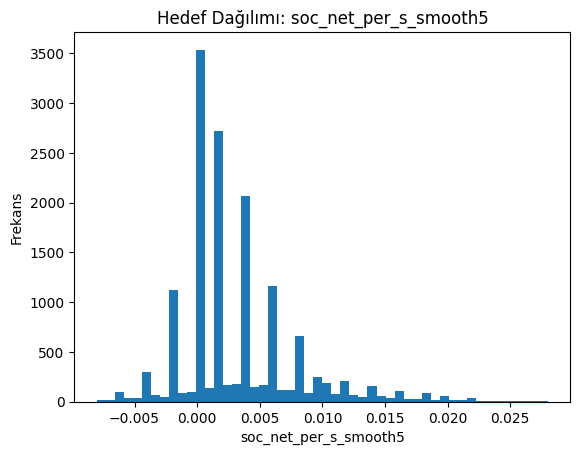

In [6]:
assert TARGET in df.columns, f"Hedef '{TARGET}' bulunamadı!"
y = pd.to_numeric(df[TARGET], errors="coerce")

print(y.describe())

plt.figure()
plt.hist(y.dropna(), bins=50)
plt.title("Hedef Dağılımı: soc_net_per_s_smooth5")
plt.xlabel("soc_net_per_s_smooth5")
plt.ylabel("Frekans")
plt.show()

## **4. Kategorik Değişkenler**

Modelin öğrenme sürecinde yalnızca sayısal veriler kullanılabilir. Bu nedenle, veri setinde bulunan kategorik değişkenlerin sayısal forma dönüştürülmesi gerekir. Bu işlem için One-Hot Encoding yöntemi uygulanmıştır.

In [7]:
# Kategorik kolonlar
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Kategorik kolonlar:", categorical_cols)
categorical_cols.remove("Experiment_ID")
print("Kategorik kolonlar:", categorical_cols)



Kategorik kolonlar: ['Experiment_ID', 'Load', 'Direction', 'Season']
Kategorik kolonlar: ['Load', 'Direction', 'Season']


In [8]:
# OneHotEncoder nesnesi
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False,drop="first")

# Sadece kategorik kolonları encode edildi
X_cat_encoded = encoder.fit_transform(df[categorical_cols])

# Yeni kolon isimlerini alındı
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

df_encoded = pd.DataFrame(X_cat_encoded, columns=encoded_col_names, index=df.index)

# Eski kategorik kolonları çıkarıp yerine encode edilmiş olanları koyuldu
df_numeric = df.drop(columns=categorical_cols).join(df_encoded)

print("Yeni şekil:", df_numeric.shape)
df_numeric.head()



Yeni şekil: (14657, 21)


,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Experiment_ID,Average_Velocity,slope,speed_ms,acc_ms2,...,cell_voltage_diff,SoC,soc_net_per_s,soc_net_per_s_smooth5,soc_net_per_s_smooth10,soc_net_per_s_30s,soc_net_per_s_60s,Load_Unloaded,Direction_MMF,Season_Winter
0,3316.50,12.56,84.68,49.687500,14.17,Experiment_1,15,0.0,0.044935,0.000000,...,7.54,60.030,0.000,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,Experiment_1,15,0.0,0.488215,0.443281,...,7.47,60.022,0.008,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,Experiment_1,15,0.0,0.968013,0.479798,...,7.83,60.020,0.002,0.0028,0.0048,0.0,0.0,0.0,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,Experiment_1,15,0.0,1.348039,0.380026,...,7.84,60.020,-0.000,0.0040,0.0048,0.0,0.0,0.0,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,Experiment_1,15,0.0,1.649832,0.301792,...,7.53,60.016,0.004,0.0032,0.0048,0.0,0.0,0.0,0.0,0.0


## **5. Random Forest Modeli Eğitimi**

## **5.1 Target = soc_net_per_s_smooth5**

### **5.1.1 Eğitim/Test Ayrımı**

Makine öğrenmesi modellerinin performansını objektif bir şekilde değerlendirebilmek için veri seti eğitim (train) ve test olmak üzere ikiye ayrılmıştır. Eğitim seti, modelin parametrelerini öğrenmesi için kullanılırken; test seti, daha önce hiç görmediği veriler üzerinde modelin doğruluğunu ölçmek için ayrılmıştır.

X → bağımsız değişkenler (özellikler, yani girişler).

y → bağımlı değişken (hedef, yani çıkış soc_net_per_s).

test_size=0.20 → verinin %20’si test setine, %80’i eğitim setine ayrılır.

random_state=RANDOM_STATE → rastgele bölmeyi tekrarlanabilir yapmak için. Böylece aynı kodu her çalıştırdığında aynı şekilde bölünür.


In [9]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "Experiment_ID",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_smooth5']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((11725, 15), (2932, 15))

### **5.1.2 Model Eğitimi**

In [10]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


**Baseline Eğitimi ve İlk Metrikler**

Elde edilen sonuçlar, modelin başlangıçta veriden ne kadar anlamlı bilgi çıkarabildiğini göstermektedir. İlk değerlendirmeler için aşağıdaki metrikler hesaplanmıştır:
* R² (Determinasyon Katsayısı): Modelin bağımlı değişkeni (enerji tüketimi) açıklama oranını gösterir.

* MAE (Ortalama Mutlak Hata): Tahmin edilen değerler ile gerçek değerler arasındaki mutlak farkların ortalamasıdır.

* RMSE (Kök Ortalama Kare Hatası): Büyük hatalara daha fazla ceza vererek modelin genel tahmin performansını ölçer.



In [11]:

y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8803
Baseline — MAE: 0.001158
Baseline — RMSE: 0.001591


### **5.1.3. Optuna ile Hiperparametre Arama**

Optuna, RandomForestRegressor modelinin hiperparametrelerini otomatik ve verimli şekilde optimize etmek için kullanılmıştır.Optuna, TPE (Tree-structured Parzen Estimator) algoritması ile çalışarak en iyi parametreleri bulmuştur. Bu sayede çapraz doğrulama üzerinde ortalama mutlak hata (MAE) minimize edilerek modelin test setindeki R², MAE ve RMSE değerleri iyileştirilmiştir.

In [12]:

!pip install optuna

import numpy as np
import optuna
from optuna.samplers import TPESampler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#  X_train, X_test, y_train, y_test, RANDOM_STATE zaten tanımlı.

def _build_rf(params, random_state, n_jobs=-1):
    if params["max_features_mode"] == "cat":
        max_features = params["max_features_cat"]          # "sqrt" veya "log2"
    else:
        max_features = params["max_features_float"]        # 0.3–1.0

    return RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=None if params["max_depth"] == "None" else params["max_depth"],
        min_samples_split=params["min_samples_split"],
        min_samples_leaf=params["min_samples_leaf"],
        max_features=max_features,
        bootstrap=True,
        random_state=random_state,
        n_jobs=n_jobs
    )

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 300, 1100, step=200)     # {300,500,700,900,1100}
    max_depth    = trial.suggest_categorical("max_depth", ["None", 10, 20, 30, 40, 60])
    min_split    = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    min_leaf     = trial.suggest_categorical("min_samples_leaf",  [1, 2, 4])

    mf_mode = trial.suggest_categorical("max_features_mode", ["cat", "float"])
    if mf_mode == "cat":
        mf_cat   = trial.suggest_categorical("max_features_cat", ["sqrt", "log2"])
        mf_float = None
    else:
        mf_cat   = None
        mf_float = trial.suggest_float("max_features_float", 0.3, 1.0, step=0.1)

    params = {
        "n_estimators": n_estimators,
        "max_depth":    max_depth,
        "min_samples_split": min_split,
        "min_samples_leaf":  min_leaf,
        "max_features_mode": mf_mode,
        "max_features_cat":  mf_cat,
        "max_features_float": mf_float,
    }

    model = _build_rf(params, random_state=RANDOM_STATE, n_jobs=-1)

    # 5-fold CV — MAE minimize
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )
    mae = -np.mean(scores)
    return mae

# Optimizasyon
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("En iyi (CV) MAE:", study.best_value)
print("En iyi parametreler:", study.best_trial.params)

# En iyi model
best_params = study.best_trial.params
rf_best = _build_rf(best_params, random_state=RANDOM_STATE, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Test performansı
y_pred = rf_best.predict(X_test)
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best RF — R²  : {r2:.4f}")
print(f"Best RF — MAE : {mae:.6f}")
print(f"Best RF — RMSE: {rmse:.6f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.6 MB/s eta 0:00:00


[I 2025-08-24 15:07:58,109] A new study created in memory with name: no-name-ba953df5-ee1b-40c8-98f3-e82137db9b08


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-24 15:08:54,891] Trial 0 finished with value: 0.0011539734962531362 and parameters: {'n_estimators': 500, 'max_depth': 'None', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features_mode': 'cat', 'max_features_cat': 'log2'}. Best is trial 0 with value: 0.0011539734962531362.
[I 2025-08-24 15:10:07,111] Trial 1 finished with value: 0.0011572983406127081 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features_mode': 'cat', 'max_features_cat': 'log2'}. Best is trial 0 with value: 0.0011539734962531362.
[I 2025-08-24 15:13:10,602] Trial 2 finished with value: 0.0011610811849211006 and parameters: {'n_estimators': 1100, 'max_depth': 'None', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features_mode': 'float', 'max_features_float': 0.4}. Best is trial 0 with value: 0.0011539734962531362.
[I 2025-08-24 15:14:25,480] Trial 3 finished with value: 0.0012352700516861969 and parameters: {'n_estimators': 1100, 'max

In [13]:
best_model = rf_best

Best — R²: 0.8900 | MAE: 0.001093 | RMSE: 0.001525


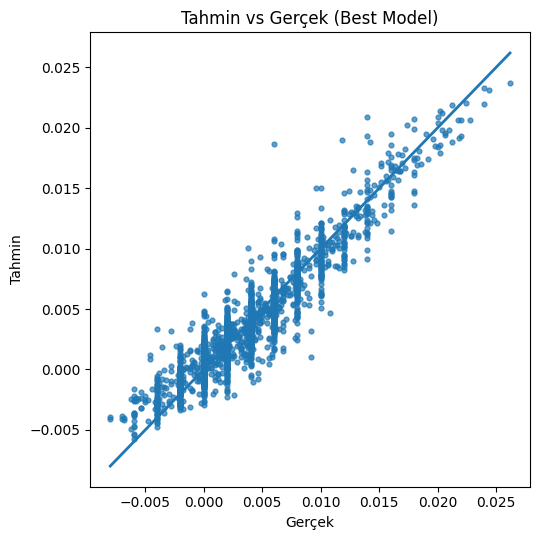

In [14]:
y_pred_best = best_model.predict(X_test)

r2  = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best — R²: {r2:.4f} | MAE: {mae:.6f} | RMSE: {rmse:.6f}")

# Tahmin vs Gerçek
plt.figure(figsize=(5.5,5.5))
plt.scatter(y_test, y_pred_best, s=12, alpha=0.7)
mn, mx = min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())
plt.plot([mn, mx], [mn, mx], linewidth=2)
plt.title("Tahmin vs Gerçek (Best Model)")
plt.xlabel("Gerçek")
plt.ylabel("Tahmin")
plt.tight_layout()
plt.show()


## **5.2 Target = soc_net_per_s_smooth10**

### **5.2.1 Eğitim/Test Ayrımı**

In [15]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "Experiment_ID",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
df_numeric.drop(columns=drop_targets ,errors ="ignore" )
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_smooth10']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 15), (2932, 15))

### **5.2.2 Model Eğitimi**

In [16]:
rf = RandomForestRegressor(
    n_estimators=900,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    max_features=0.30,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [17]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8610
Baseline — MAE: 0.000991
Baseline — RMSE: 0.001494


## **5.3 Target = soc_net_per_s_30s**

### **5.3.1 Eğitim/Test Ayrımı**

In [18]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "Experiment_ID",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_30s']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 15), (2932, 15))

### **5.3.2 Model Eğitimi**

In [19]:
rf = RandomForestRegressor(
    n_estimators=900,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    max_features=0.30,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [20]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8614
Baseline — MAE: 0.000816
Baseline — RMSE: 0.001243


## **5.4 Target = soc_net_per_s_60s**

### **5.4.1 Eğitim/Test Ayrımı**

In [21]:
# Üstte sayısal olarak belirlediğimiz değişkenleri X'e atıyoruz.
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth5",
    "soc_net_per_s_smooth10",
    "Experiment_ID",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
X = df_numeric.drop(columns=drop_targets ,errors ="ignore" )

# Hedef değişkeni y'ye atıyoruz.
y = df_numeric['soc_net_per_s_60s']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((11725, 15), (2932, 15))

### **5.4.2 Model Eğitimi**

In [22]:
rf = RandomForestRegressor(
    n_estimators=900,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    max_features=0.30,
    bootstrap=True,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [23]:
y_pred = rf.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline — R² : {r2:.4f}")
print(f"Baseline — MAE: {mae:.6f}")
print(f"Baseline — RMSE: {rmse:.6f}")

Baseline — R² : 0.8789
Baseline — MAE: 0.000680
Baseline — RMSE: 0.001046


## **5.5 Grup Bazlı Bölme**

**GroupShuffleSplit** kullanılarak her **Experiment_ID** sadece bir sette (train/val/test) olacak şekilde ayırma yapılmıştır.

Bu yöntem, aynı sürüşten gelen gözlemlerin farklı setlere dağılmasını engelleyerek **veri sızıntısı riskini ortadan kaldırır.**

Böylece modelin test performansı, gerçekten hiç görmediği yeni bir sürüş senaryosu üzerinde ölçülmektedir.

In [24]:
drop_targets = {
    "soc_net_per_s",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
df_numeric.drop(columns=drop_targets ,inplace=True )
df_numeric.head()

,CELL_V_AVG,Torque_Measured,MotorTemperature,DC_Link_Voltage,DC_Link_Current,Experiment_ID,Average_Velocity,slope,speed_ms,acc_ms2,power_W,cell_voltage_diff,SoC,soc_net_per_s_smooth5,Load_Unloaded,Direction_MMF,Season_Winter
0,3316.50,12.56,84.68,49.687500,14.17,Experiment_1,15,0.0,0.044935,0.000000,704.071875,7.54,60.030,0.0028,0.0,0.0,0.0
1,3313.15,24.26,84.52,49.593125,30.35,Experiment_1,15,0.0,0.488215,0.443281,1505.151344,7.47,60.022,0.0028,0.0,0.0,0.0
2,3311.55,22.00,84.47,49.530625,34.48,Experiment_1,15,0.0,0.968013,0.479798,1707.815950,7.83,60.020,0.0028,0.0,0.0,0.0
3,3309.89,22.52,84.65,49.482500,41.73,Experiment_1,15,0.0,1.348039,0.380026,2064.904725,7.84,60.020,0.0040,0.0,0.0,0.0
4,3308.00,23.06,84.63,49.441875,47.54,Experiment_1,15,0.0,1.649832,0.301792,2350.466737,7.53,60.016,0.0032,0.0,0.0,0.0


In [25]:


# Gruplama değişkeni
groups = df_numeric["Experiment_ID"]

# Özellikler (X) ve hedef (y)
X = df_numeric.drop(columns=["Experiment_ID", "soc_net_per_s_smooth5"])
y = df_numeric["soc_net_per_s_smooth5"]

def group_split(X, y, groups, test_size=0.15, val_size=0.15, rs=42):
    """
    X, y ve groups'u alır; önce TEST setini, sonra kalan içinden VALIDATION setini ayırır.
    NOT: Aynı 'Experiment_ID' birden fazla sete dağılmaz.
    """
    # 1) Önce train+val vs test ayrımı
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
    i_tr, i_te = next(gss.split(X, y, groups))

    # 2) train içinden validation ayırma
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=rs)
    j_tr, j_val = next(gss2.split(X.iloc[i_tr], y.iloc[i_tr], groups.iloc[i_tr]))

    # Indexleri belirleme
    tr_idx = X.iloc[i_tr].index[j_tr]
    val_idx = X.iloc[i_tr].index[j_val]
    te_idx = X.index[i_te]

    return tr_idx, val_idx, te_idx

# Split uygula
train_idx, val_idx, test_idx = group_split(X, y, groups)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]


# Kontrol çıktıları
print(f"Split -> Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
print("\nEğitim için kullanılacak özelliklerin bilgi özeti:")
X_train.info()


Split -> Train: 10224, Val: 2274, Test: 2159

Eğitim için kullanılacak özelliklerin bilgi özeti:
<class 'pandas.core.frame.DataFrame'>
Index: 10224 entries, 0 to 14656
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CELL_V_AVG         10224 non-null  float64
 1   Torque_Measured    10224 non-null  float64
 2   MotorTemperature   10224 non-null  float64
 3   DC_Link_Voltage    10224 non-null  float64
 4   DC_Link_Current    10224 non-null  float64
 5   Average_Velocity   10224 non-null  int64  
 6   slope              10224 non-null  float64
 7   speed_ms           10224 non-null  float64
 8   acc_ms2            10224 non-null  float64
 9   power_W            10224 non-null  float64
 10  cell_voltage_diff  10224 non-null  float64
 11  SoC                10224 non-null  float64
 12  Load_Unloaded      10224 non-null  float64
 13  Direction_MMF      10224 non-null  float64
 14  Season_Winter      10224 n

In [26]:
rf = RandomForestRegressor(
    n_estimators=900,
    max_depth=60,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    max_features=0.30,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


In [27]:
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

from sklearn.metrics import mean_absolute_error

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Validation ->  RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | R²: {r2_val:.4f}")
print(f"Test       -> MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | R²: {r2_test:.4f}")

Validation ->  RMSE: 0.0019 | MAE: 0.0014 | R²: 0.8632
Test       -> MSE: 0.0000 | RMSE: 0.0019 | MAE: 0.0014 | R²: 0.8632


## **6. Menzil Tahmini (Range)**

In [28]:


PRED_COL = "y_pred_soc_rate_pps"
usable_kwh_est = 15.6  # sabit kullanılabilir kapasite (kWh)
DEFAULT_DT = 1.0       # saniye


df[PRED_COL] = rf_best.predict(X)   # dataset için tahminler
print(f"[OK] {PRED_COL} eklendi. Örnek:", df[PRED_COL].head(3).round(6).tolist())

# Deney bazlı kalan menzil hesaplama
rows = []
for exp_id, g in df.groupby("Experiment_ID"):

    # MODEL tabanlı enerji kullanımı (kWh)
    # RF çıktısı = ΔSoC/s → enerjiye çevirmek için kapasiteyle ölçeklenir
    pred_energy_kwh_per_s = usable_kwh_est * (g[PRED_COL] / 100.0)
    energy_kwh = float((pred_energy_kwh_per_s * DEFAULT_DT).sum())


    if "delta_dist" in g.columns:
        dist_km = g["delta_dist"].sum() / 1000.0
    else:
        dist_km = 2.0  # geçici sabit

    if energy_kwh <= 0 or dist_km <= 0:
        continue

    # MODEL ortalama tüketim (kWh/km)
    avg_cons = energy_kwh / dist_km

    # Deney sonundaki SoC ve kalan enerji
    soc_end = float(g["SoC"].iloc[-1])
    remaining_kwh = usable_kwh_est * soc_end / 100.0

    # Kalan menzil (km)
    remaining_range_km = remaining_kwh / avg_cons if avg_cons > 0 else np.nan

    rows.append({
        "Experiment_ID": exp_id,
        "model_avg_cons_kWh_per_km": avg_cons,
        "SoC_end_%": soc_end,
        "remaining_kWh": remaining_kwh,
        "Remaining_Range_km_MODEL": remaining_range_km,
        "model_energy_used_kWh": energy_kwh
    })

# 3) Tabloya dök
exp_remaining_df = (
    pd.DataFrame(rows)
      .sort_values("Experiment_ID")
      .reset_index(drop=True)
)

exp_remaining_df.index = exp_remaining_df.index + 1

display(exp_remaining_df.head(35))



[OK] y_pred_soc_rate_pps eklendi. Örnek: [0.002328, 0.002415, 0.002605]


,Experiment_ID,model_avg_cons_kWh_per_km,SoC_end_%,remaining_kWh,Remaining_Range_km_MODEL,model_energy_used_kWh
1,Experiment_1,0.119041,58.48,9.12288,76.636577,0.238082
2,Experiment_10,0.073412,51.96,8.10576,110.415064,0.146823
3,Experiment_11,0.066492,65.59,10.23204,153.884041,0.132984
4,Experiment_12,0.068982,64.71,10.09476,146.338395,0.137965
5,Experiment_13,0.139207,63.50,9.90600,71.160456,0.278413
6,Experiment_14,0.115251,58.26,9.08856,78.858550,0.230503
7,Experiment_15,0.011998,56.62,8.83272,736.156882,0.023997
8,Experiment_16,0.126309,61.49,9.59244,75.944266,0.252618
9,Experiment_17,0.105294,46.32,7.22592,68.626130,0.210588
10,Experiment_18,0.099812,45.02,7.02312,70.363298,0.199625


1. **Tüketim (kWh/100km) – Menzil (km) ilişkisi**

    * **Yüksek tüketim → düşük menzil**

    Örn. Experiment_5 → tüketim ≈ 0.093 kWh/km , menzil ≈ 73 km.

    Bu yüksek bir tüketim, doğal olarak menzil çok kısa.

    * **Düşük tüketim → yüksek menzil**

    Örn. Experiment_11 → tüketim ≈ 0.066 kWh/km, menzil ≈ 154 km.

    Verimli sürüş, daha uzun menzil.



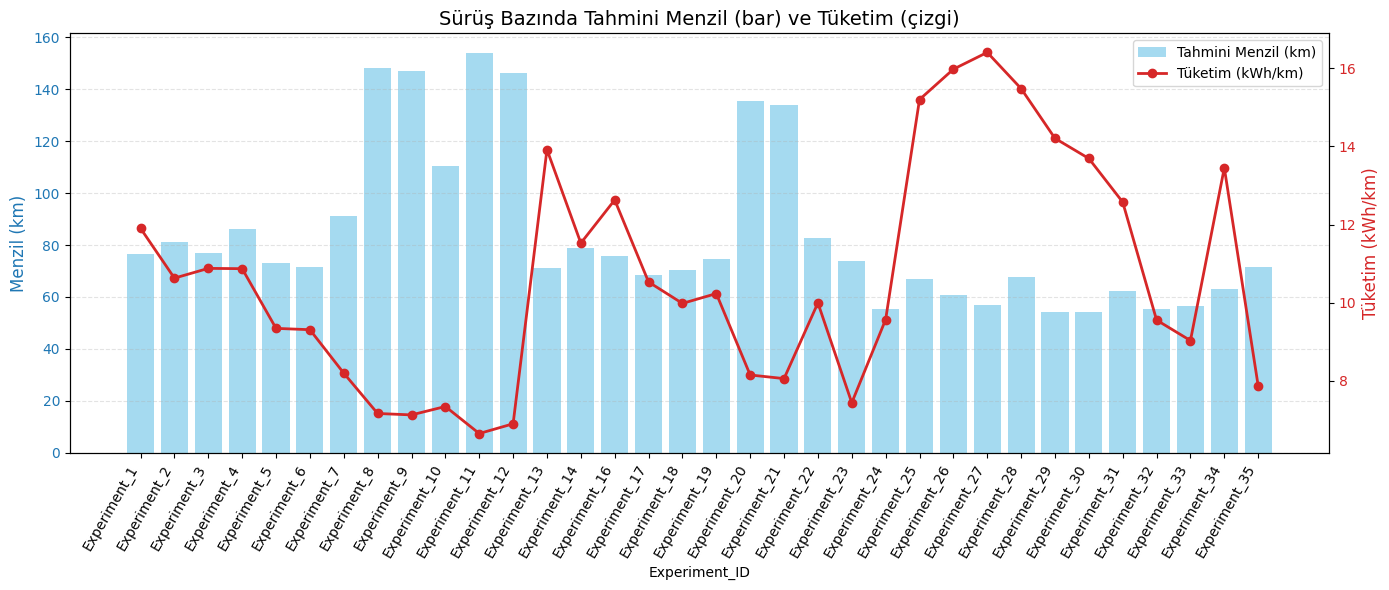

In [29]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exp_remaining_df = exp_remaining_df[
    ~exp_remaining_df["Experiment_ID"].astype(str).str.strip().eq("Experiment_15")
].reset_index(drop=True)

def plot_range_and_consumption(exp_df: pd.DataFrame,
                               gcol: str = "Experiment_ID",
                               range_col: str = "Remaining_Range_km_MODEL",
                               cons_col: str = "model_avg_cons_kWh_per_km",
                               to_100km: bool = False,
                               ignore: list[str] = None,
                               figsize=(14,6),
                               rotation=60):
    dfp = exp_df.copy()

    if ignore:
        dfp = dfp[~dfp[gcol].isin(ignore)].copy()

    #  sütun kontrolü
    missing = [c for c in [gcol, range_col, cons_col] if c not in exp_df.columns]
    if missing:
        raise KeyError(f"Eksik kolon(lar): {missing}")

    dfp = exp_df[[gcol, range_col, cons_col]].copy()

    def _expnum(s):
        m = re.search(r"(\d+)", str(s))
        return int(m.group(1)) if m else np.inf
    dfp["__order"] = dfp[gcol].map(_expnum)
    dfp = dfp.sort_values(["__order", gcol]).drop(columns="__order").reset_index(drop=True)

    #  X ekseni
    x = np.arange(len(dfp))
    labels = dfp[gcol].tolist()

    #  Değerler
    y_range = dfp[range_col].to_numpy()
    y_cons  = dfp[cons_col].to_numpy()
    if to_100km:
        y_cons = y_cons * 100.0
        cons_label = "Tüketim (kWh/km)"
    else:
        cons_label = "Tüketim (kWh/km)"

    #  Çizim
    fig, ax1 = plt.subplots(figsize=figsize)

    bars = ax1.bar(x, y_range, color="skyblue", alpha=0.75, label="Tahmini Menzil (km)")
    ax1.set_ylabel("Menzil (km)", color="tab:blue", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(axis="y", linestyle="--", alpha=0.35)

    ax2 = ax1.twinx()
    line, = ax2.plot(x, y_cons, color="tab:red", marker="o", linewidth=2, label=cons_label)
    ax2.set_ylabel(cons_label, color="tab:red", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    step = max(1, len(labels)//30)
    ax1.set_xticks(x[::step])
    ax1.set_xticklabels([labels[i] for i in range(0, len(labels), step)], rotation=rotation, ha="right")

    ax1.set_xlabel(gcol)
    ax1.set_title("Sürüş Bazında Tahmini Menzil (bar) ve Tüketim (çizgi)", fontsize=14)
    handles = [bars, line]
    labels_leg = [h.get_label() for h in handles]
    ax1.legend(handles, labels_leg, loc="upper right")

    plt.tight_layout()
    plt.show()

plot_range_and_consumption(exp_remaining_df, to_100km=True, ignore=["Experiment_15"])


## **7. Model Tahmini ve Karşılaştırma**

**7.1 Anlık Tahmin**

Eğitilen model (RF/XGBoost/NN fark etmeksizin) her kayıt için SoC düşüş hızını tahmin eder (pp/s).
Bu tahminler y_pred_soc_rate_pps kolonunda tutulur.

* Yüksek *y_pred_soc_rate_pps* → birim zamanda daha fazla SoC kaybı → daha yüksek tüketim.

* Bu anlık tahminler deney bazında toplanarak enerji, tüketim ve kalan menzil hesaplarına temel oluşturur.

**7.2 Deney Bazlı Model Çıktıları**

Her Experiment_ID için model tahminlerinden türetilen özet metrikler:

* *model_avg_cons_kWh_per_km*: Modelin hesapladığı ortalama enerji tüketimi (kWh/
km).

* *SoC_end_%*: Deney sonunda bataryada kalan SoC (%).

* *remaining_kWh*: Deney sonunda kalan kullanılabilir enerji (kWh).

* *Remaining_Range_km_MODEL*: Modele göre tahmini kalan menzil (km).

* *model_energy_used_kWh*: Deney boyunca tahmini kullanılan enerji (kWh).


**7.3 Gerçek vs. Model Karşılaştırması**

Aynı deneyler için gerçek ve model sonuçları yan yana kıyaslanır:

* *true_avg_cons_kWh/km*: Gerçek SoC düşüşünden hesaplanan ortalama tüketim (kWh/km).

* *pred_avg_cons_kWh/km*: Model tahminlerinden türetilen ortalama tüketim (kWh/km).

* *true_remaining_range_km*: Gerçek kalan menzil (km).

* *pred_remaining_range_km*: Model tahmini kalan menzil (km).

* *delta_range_km*: Model – Gerçek menzil farkı (km).

* *perc_error_%*: Modelin menzili ne kadar fazla/eksik tahmin ettiği (%).

In [30]:
# GERÇEK VS MODEL TABANLI KALAN MENZİL KARŞILAŞTIRMA

rows = []
usable_kwh_est = 15.6
DEFAULT_DT = 1.0
GROUP_COL = "Experiment_ID"

for exp_id, g in df.groupby(GROUP_COL, sort=False):
    if g["SoC"].isna().any():
        continue

    # --- Gerçek Değerler ---
    soc_start = float(g["SoC"].iloc[0])
    soc_end   = float(g["SoC"].iloc[-1])
    soc_drop  = soc_start - soc_end

    dist_km = 2.0

    true_energy_used = usable_kwh_est * (soc_drop / 100.0)
    if dist_km <= 0 or true_energy_used <= 0:
        continue

    true_avg_cons = true_energy_used / dist_km
    remaining_kwh = usable_kwh_est * soc_end / 100.0
    true_remaining = remaining_kwh / true_avg_cons if true_avg_cons > 0 else np.nan

    # --- Model Tahminleri ---
    pred_energy_kwh_per_s = usable_kwh_est * (g[PRED_COL].to_numpy() / 100.0)
    pred_energy_used = float(pred_energy_kwh_per_s.sum())

    if pred_energy_used <= 0:
        continue

    pred_avg_cons = pred_energy_used / dist_km
    pred_remaining = remaining_kwh / pred_avg_cons if pred_avg_cons > 0 else np.nan

    # --- Satır ekle ---
    rows.append({
        "Experiment_ID": exp_id,
        "true_avg_cons_kWh/km": true_avg_cons,
        "pred_avg_cons_kWh/km": pred_avg_cons,
        "true_remaining_range_km": true_remaining,
        "pred_remaining_range_km": pred_remaining,
        "delta_range_km": pred_remaining - true_remaining,
        "perc_error_%": (100.0 * (pred_remaining - true_remaining) / true_remaining)
                        if true_remaining > 0 else np.nan
    })

compare_df = pd.DataFrame(rows)

compare_df["Exp_Num"] = compare_df["Experiment_ID"].str.extract(r'(\d+)').astype(int)
compare_df = compare_df.sort_values("Exp_Num").drop(columns="Exp_Num").reset_index(drop=True)

display(compare_df.head(35))


,Experiment_ID,true_avg_cons_kWh/km,pred_avg_cons_kWh/km,true_remaining_range_km,pred_remaining_range_km,delta_range_km,perc_error_%
0,Experiment_1,0.120900,0.119041,75.458065,76.636577,1.178512,1.561811
1,Experiment_2,0.107640,0.106284,79.985507,81.005970,1.020462,1.275809
2,Experiment_3,0.107640,0.108782,77.927536,77.109634,-0.817902,-1.049567
3,Experiment_4,0.111540,0.108708,83.986014,86.174141,2.188127,2.605347
4,Experiment_5,0.092040,0.093420,74.288136,73.191096,-1.097039,-1.476736
5,Experiment_6,0.093600,0.093079,71.050000,71.447915,0.397915,0.560049
6,Experiment_7,0.081900,0.081952,91.390476,91.332679,-0.057797,-0.063242
7,Experiment_8,0.072540,0.071624,146.494624,148.367677,1.873053,1.278582
8,Experiment_9,0.072540,0.071260,144.430108,147.024618,2.594510,1.796378
9,Experiment_10,0.076440,0.073412,106.040816,110.415064,4.374247,4.125060


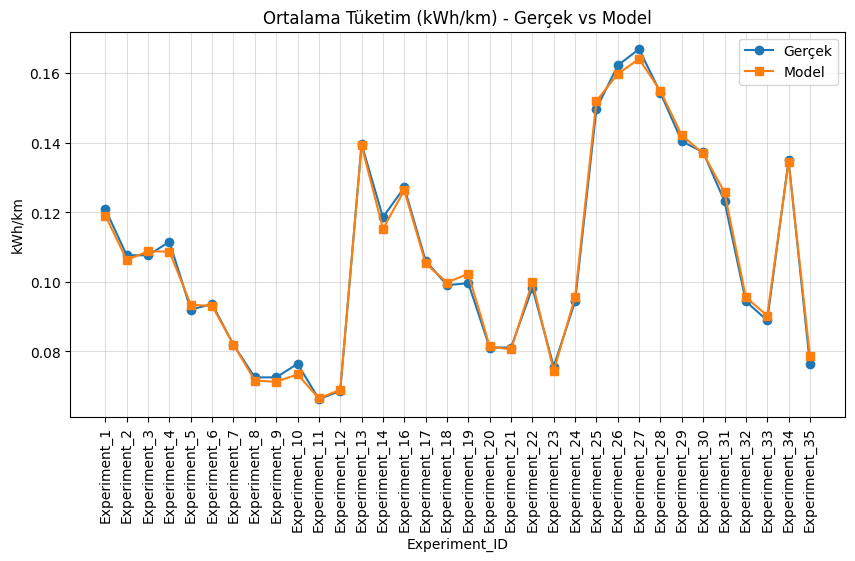

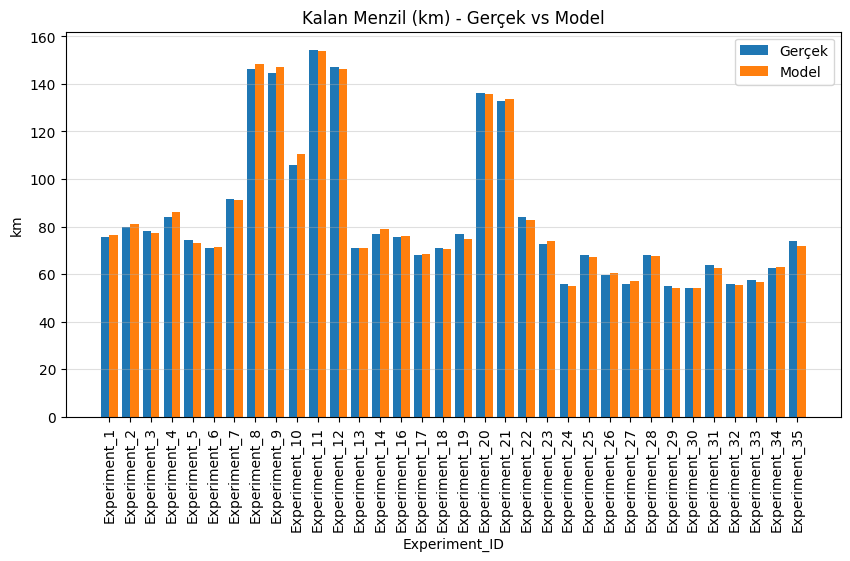

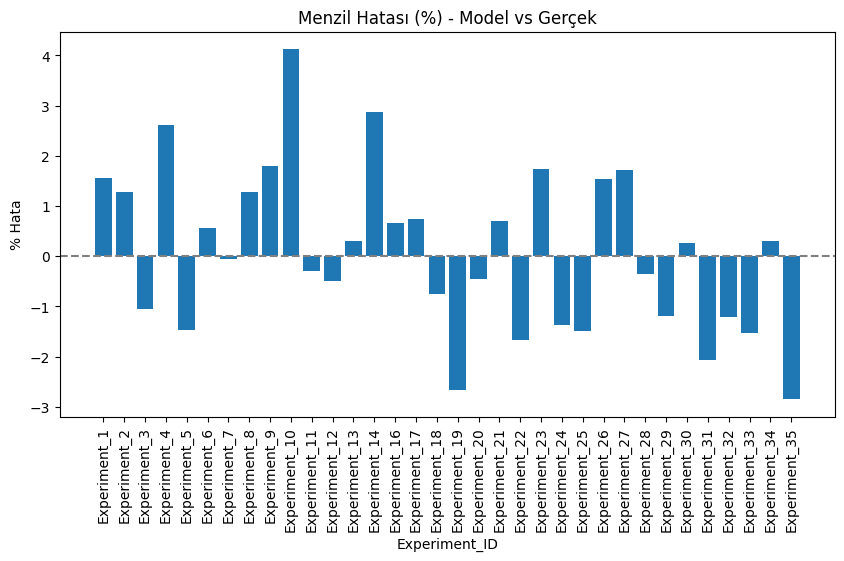

In [31]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def _order_exp(df, gcol="Experiment_ID", ignore=None):
    dfc = df.copy()
    if ignore:
        dfc = dfc[~dfc[gcol].isin(ignore)].copy()
    dfc["__num"] = dfc[gcol].astype(str).str.extract(r"(\d+)").astype(int)
    dfc = dfc.sort_values("__num").drop(columns="__num").reset_index(drop=True)
    return dfc

# 1) Ortalama tüketim (kWh/km): Gerçek vs Model
def plot_avg_consumption(compare_df: pd.DataFrame, savepath: str | None = None, ignore=["Experiment_15"]):
    cdf = _order_exp(compare_df, ignore=ignore)
    x = cdf["Experiment_ID"]
    y_true = cdf["true_avg_cons_kWh/km"]
    y_pred = cdf["pred_avg_cons_kWh/km"]

    plt.figure(figsize=(10,5))
    plt.plot(x, y_true, marker="o", label="Gerçek")
    plt.plot(x, y_pred, marker="s", label="Model")
    plt.title("Ortalama Tüketim (kWh/km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID")
    plt.ylabel("kWh/km")
    plt.xticks(rotation=90)
    plt.legend(); plt.grid(True, alpha=0.4)
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()

# 2) Kalan menzil (km): Gerçek vs Model
def plot_remaining_range(compare_df: pd.DataFrame, savepath: str | None = None, ignore=["Experiment_15"]):
    cdf = _order_exp(compare_df, ignore=ignore)
    x = np.arange(len(cdf)); width = 0.4

    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, cdf["true_remaining_range_km"], width=width, label="Gerçek")
    plt.bar(x + width/2, cdf["pred_remaining_range_km"], width=width, label="Model")
    plt.title("Kalan Menzil (km) - Gerçek vs Model")
    plt.xlabel("Experiment_ID"); plt.ylabel("km")
    plt.xticks(x, cdf["Experiment_ID"].tolist(), rotation=90)
    plt.legend(); plt.grid(axis="y", alpha=0.4)
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()

# 3) Menzil hatası (%): Model - Gerçek
def plot_range_error_percent(compare_df: pd.DataFrame, savepath: str | None = None, ignore=["Experiment_15"]):
    cdf = _order_exp(compare_df, ignore=ignore)
    if "perc_error_%" not in cdf.columns:
        cdf["perc_error_%"] = 100.0 * (
            (cdf["pred_remaining_range_km"] - cdf["true_remaining_range_km"])
            / cdf["true_remaining_range_km"].replace(0, np.nan)
        )

    plt.figure(figsize=(10,5))
    plt.bar(cdf["Experiment_ID"], cdf["perc_error_%"])
    plt.title("Menzil Hatası (%) - Model vs Gerçek")
    plt.xlabel("Experiment_ID"); plt.ylabel("% Hata")
    plt.xticks(rotation=90)
    plt.axhline(0, linestyle="--", color="gray")
    if savepath: plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()
plot_avg_consumption(compare_df)
plot_remaining_range(compare_df)
plot_range_error_percent(compare_df)



# **Faktörlerin Anlık Tüketime Etkisi**

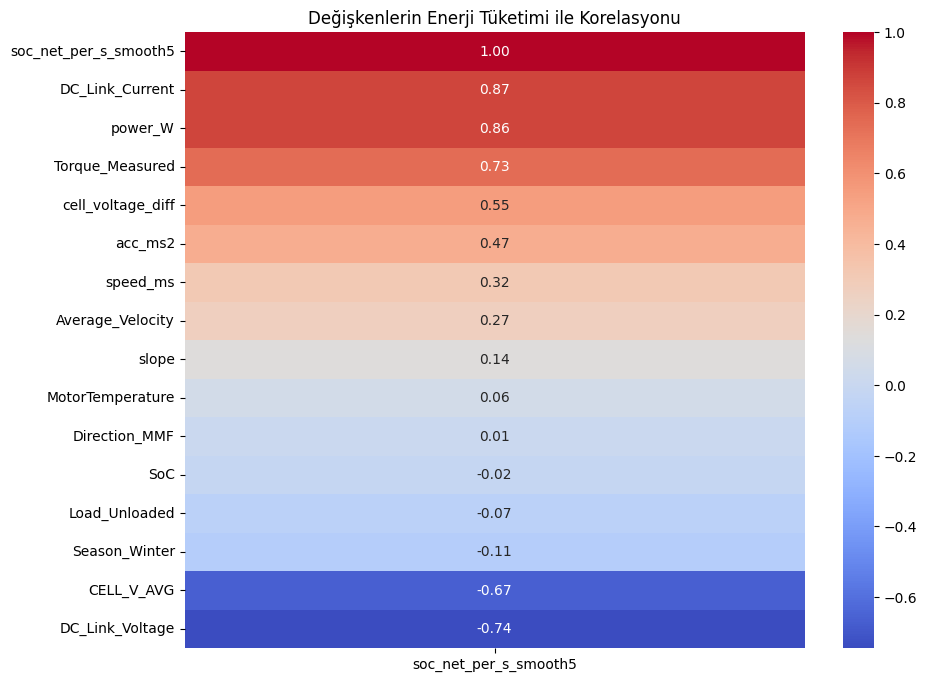

In [32]:
drop_targets = {
    "soc_net_per_s",
    "Experiment_ID",
    "soc_net_per_s_smooth10",
    "soc_net_per_s_30s",
    "soc_net_per_s_60s"
}
df_numeric.drop(columns=drop_targets ,errors ="ignore" )
corr = df_numeric.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr[['soc_net_per_s_smooth5']].sort_values(by='soc_net_per_s_smooth5', ascending=False),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Değişkenlerin Enerji Tüketimi ile Korelasyonu")
plt.show()

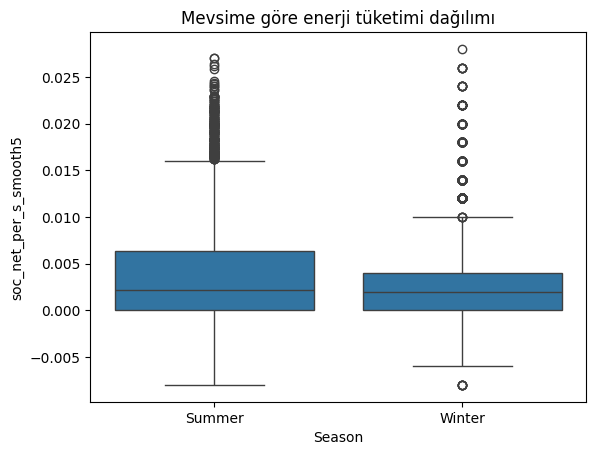

In [33]:
sns.boxplot(x="Season", y="soc_net_per_s_smooth5", data=df)
plt.title("Mevsime göre enerji tüketimi dağılımı")
plt.show()

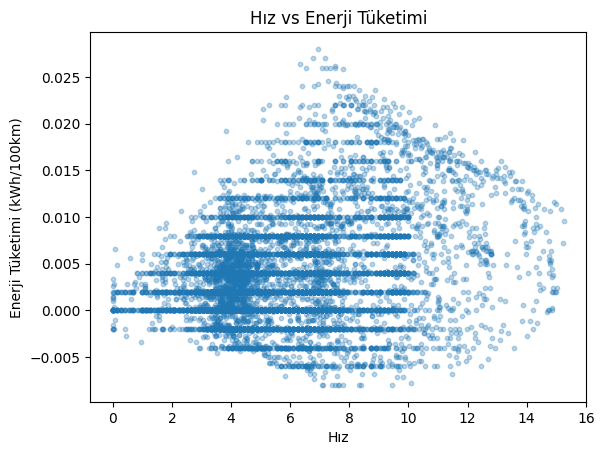

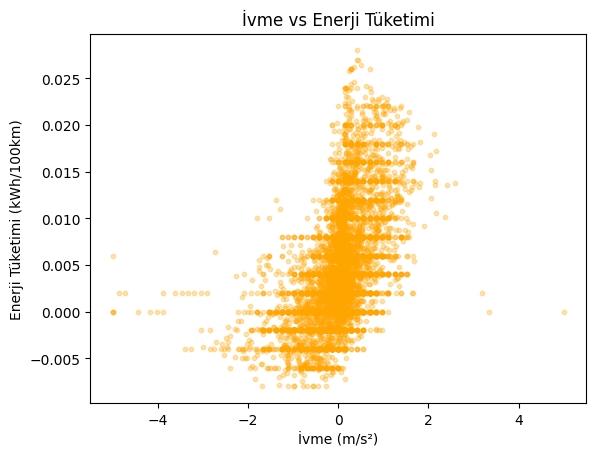

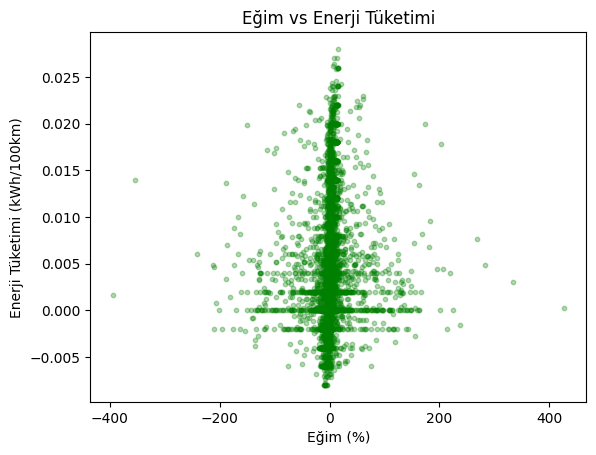

In [34]:
# Hız ve Tüketim
plt.scatter(df["speed_ms"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10)
plt.xlabel("Hız")
plt.ylabel("Enerji Tüketimi (kWh/100km)")
plt.title("Hız vs Enerji Tüketimi")
plt.show()

# İvme ve Tüketim
plt.scatter(df["acc_ms2"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="orange")
plt.xlabel("İvme (m/s²)")
plt.ylabel("Enerji Tüketimi (kWh/100km)")
plt.title("İvme vs Enerji Tüketimi")
plt.show()

# Eğim ve Tüketim
plt.scatter(df["slope"], df["soc_net_per_s_smooth5"], alpha=0.3, s=10, color="green")
plt.xlabel("Eğim (%)")
plt.ylabel("Enerji Tüketimi (kWh/100km)")
plt.title("Eğim vs Enerji Tüketimi")
plt.show()

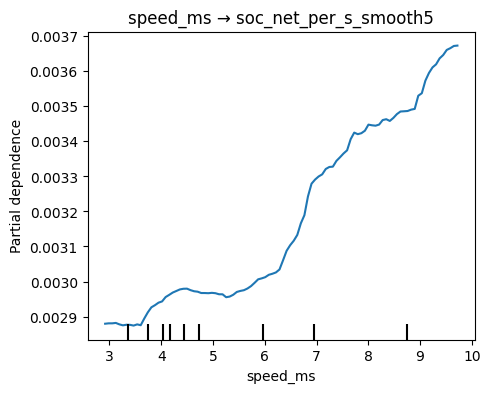

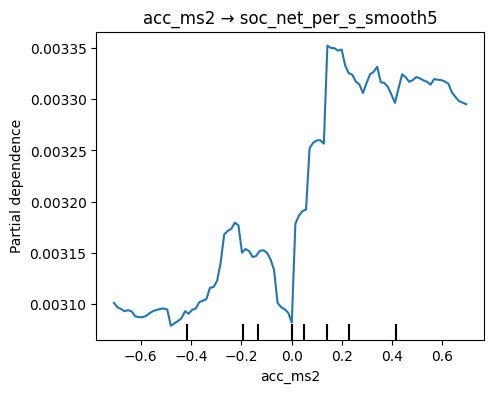

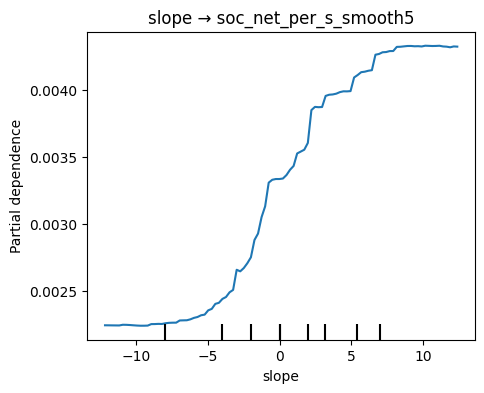

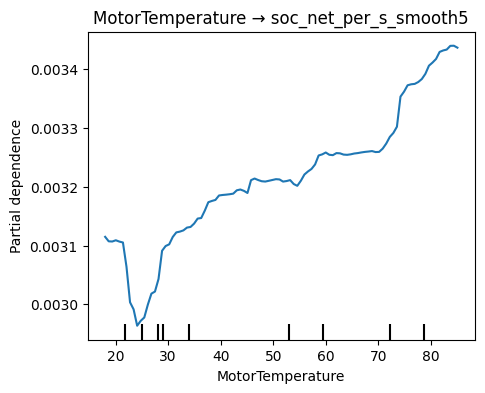

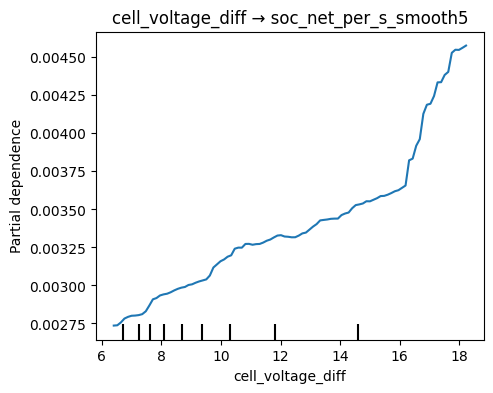

In [35]:
features = [f for f in ["speed_ms","acc_ms2","slope","MotorTemperature","cell_voltage_diff"] if f in X_train.columns]
for feat in features:
    fig, ax = plt.subplots(figsize=(5,4))
    PartialDependenceDisplay.from_estimator(rf_best, X_train, [feat], ax=ax)
    plt.title(f"{feat} → soc_net_per_s_smooth5")
    plt.show()